In [3]:
import numpy as np
import glob, os, sys
import xarray as xr
import pandas as pd
from netCDF4 import Dataset
# from scipy.ndimage import label, binary_dilation, binary_erosion, generate_binary_structure
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.signal import fftconvolve
from skimage import data, draw
from skimage.feature import masked_register_translation
from scipy import ndimage as ndi

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline

In [9]:
def offset_to_speed(x, y, time_lag, dx=.5, dy=.5):
    """ Return normalized speed assuming uniform grid.
    """
    mag_movement = np.sqrt((dx*x)**2 + (dy*y)**2)
    mag_dir = np.arctan2(x*dx, y*dy)*180/np.pi
    mag_movement_mps = np.array([mag_movement_i / (time_lag) * 1000.0 for mag_movement_i in mag_movement.T]).T
    return mag_movement, mag_dir, mag_movement_mps
def get_pixel_size_of_clouds(dataset, total_tracks, track_variable='pcptracknumber'):

    """ Calculate pixel size of each identified cloud in the file.
    Parameters:
    -----------
    dataset: Dataset
        netcdf Dataset
    track_variable: string
        variable that contains pixel level values.
    Returns:
    --------
    counts: array_like
        Pixel size of every cloud in file. Cloud 0 is stored at 0.
    """
    storm_sizes = np.zeros(total_tracks+1)

    track, counts = np.unique(dataset.variables[track_variable][:], return_counts=True)
    storm_sizes[track] = counts
    storm_sizes[0] = 0
    return storm_sizes

In [155]:
datadir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/'
figdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/advection_demo/'
os.makedirs(figdir, exist_ok=True)

filelist = sorted(glob.glob(f'{datadir}/*20190125.*.nc'))
print(f'Found {len(filelist)} files.')
# fun_file_idx = [36, 126]
test_file_idx = 54
filename_1 = filelist[test_file_idx]
filename_2 = filelist[test_file_idx+1]

print(f'Starting with file: {filename_1}, {filename_2}')

Found 71 files.
Starting with file: /lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/taranis_corcsapr2cfrppiqcM1_convmask.c1.20190125.194503.nc, /lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/taranis_corcsapr2cfrppiqcM1_convmask.c1.20190125.200003.nc


In [150]:
dset_1 = xr.open_dataset(filename_1)
reflectivity_1 = dset_1['dbz_comp'].values

dset_2 = xr.open_dataset(filename_2)
reflectivity_2 = dset_2['dbz_comp'].values

In [151]:
fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
figname = figdir + fignametimestr + '.png'
figname

'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/advection_demo/20190125_1945.png'

In [152]:
def movement_of_storm_fft(dset_1,
                          dset_2,
                          figname,
                          cuts = 1,
                          times=None,
                          threshold = 30,
                          plot_subplots=False, 
                          buffer=30, 
                          size_threshold=10,
                         ):

    """ Calculate Movement of first labeled storm
    Parameters
    ----------
    field_1: str
        Current field (t=0)
    field_2: str
        t=1 field
    """
    field_1 = np.squeeze(dset_1['dbz_comp'].values)
    field_2 = np.squeeze(dset_2['dbz_comp'].values)
    xx = dset_1.x.values / 1000.
    yy = dset_1.y.values / 1000.
    timestr1 = dset_1.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
    timestr2 = dset_2.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
    fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
    

    y_lag = np.zeros((cuts, cuts))
    x_lag = np.zeros((cuts, cuts))

    # mask_1 = np.logical_or(np.squeeze(dset_1['conv_mask_inflated'].values> 0), field_1>thresh)
    # mask_2 = np.logical_or(np.squeeze(dset_2['conv_mask_inflated'].values> 0), field_2>thresh)

    mask_1 = field_1>threshold
    mask_2 = field_2>threshold

    # field_1[field_1 < thresh] = -60
    # field_2[field_2 < thresh] = -60 # May cause issues with convolution later. 

    # field_1[np.logical_not(mask_1)] = thresh
    # field_2[np.logical_not(mask_2)] = thresh # May cause issues with convolution later. 

    dimensions = field_1.shape
    x_skip = int(dimensions[0]/cuts)
    y_skip = int(dimensions[1]/cuts)

    # Mask each region into a cut
    for col in range(0,cuts):
        for row in range(0, cuts):
            mask = np.zeros(field_1.shape)
            mask[buffer + row*x_skip : (row+1)*x_skip-buffer, buffer+col*y_skip: (col+1)*y_skip-buffer] = 1
            mask= mask * mask_1
            mask[field_1<-100] = 0
            mask_2[field_2<-100] = 0


            num_points = np.sum(mask > 0)
            y, x = -1 * masked_register_translation(field_1, field_2, mask_1, mask_2, overlap_ratio=.7)

            if plot_subplots:
                mpl.rcParams['font.size'] = 12
                mpl.rcParams['font.family'] = 'Helvetica'

                fig = plt.figure(constrained_layout=True, figsize=[8,9.5], dpi=100)
                gs = fig.add_gridspec(3, 3, height_ratios=[1,1,1], width_ratios=[1,1,0.06])
                gs.update(right=0.8, wspace=0.06, hspace=0.05)

                ax1 = fig.add_subplot(gs[0, 0])
#                 pcm1 = ax1.pcolormesh(xx, yy, field_1*mask, vmin=-10, vmax=60, cmap='gist_ncar')
                pcm1 = ax1.pcolormesh(xx, yy, field_1, vmin=-10, vmax=60, cmap='gist_ncar')
                ct1 = ax1.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
                ax1.set_title(f'(a) {timestr1}', loc='left')
                ax1.set_ylabel('Y (km)')
                ax1.grid(ls='--')

                ax2 = fig.add_subplot(gs[0, 1])
#                 pcm2 = ax2.pcolormesh(xx, yy, field_2*mask_2, vmin=-10, vmax=60, cmap='gist_ncar')
                pcm2 = ax2.pcolormesh(xx, yy, field_2, vmin=-10, vmax=60, cmap='gist_ncar')
                ct2 = ax2.contour(xx, yy, 2*mask_2, vmin=-1, vmax=1, cmap='binary', levels=3)
                ax2.set_title(f'(b) {timestr2}', loc='left')
                ax2.grid(ls='--')
                
                ax3 = fig.add_subplot(gs[1:, 0:2])
                # Plot field_2
                pcm3 = ax3.pcolormesh(xx, yy, field_2*mask_2, vmin=-10, vmax=60, cmap='gist_ncar')
                shifted_field_1 = ndi.shift(mask_1, [ int(y), int(x)])
                # Plot outline of field_1 after shift
                ct2 = ax3.contour(xx, yy, 2*shifted_field_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
                # Plot outline of field_1 original
                ct1 = ax3.contour(xx, yy, -2*mask_1, vmin=-1, vmax=1, cmap='seismic', levels=3)
                # Plot advection arrow
                ar = ax3.arrow(-75, 0, x, y, width=1, head_width=5, facecolor='k', edgecolor='k')
                ax3.set_title(f'(c) Advection Estimate', loc='left')
                ax3.set_xlabel('X (km)')
                ax3.set_ylabel('Y (km)')
                ax3.grid(ls='--')
                
                # Colorbar
                cb_ax = fig.add_subplot(gs[:,2])
                cbar = fig.colorbar(pcm1, cax=cb_ax, label='Composite Reflectivity (dBZ)')
                # Custom legend
                cmap = plt.get_cmap('seismic')
                custom_lines = [mpl.lines.Line2D([0], [0], color=cmap(0.), lw=4),
                                mpl.lines.Line2D([0], [0], color=cmap(1.), lw=4)]
                ax3.legend(custom_lines, ['Time (a)', 'Time (a) Shifted'], loc='upper left')
                fig.savefig(figname, dpi=300, bbox_inches='tight')
                

            if num_points < size_threshold:
                x_lag[row, col] = np.nan
                y_lag[row, col] = np.nan
                continue


            y_lag[row, col] = y
            x_lag[row, col] = x


    mag_movement, mag_dir, mag_movement_mps = offset_to_speed(x_lag, y_lag, 15 * 60)

    x_lag[mag_movement_mps > 60] = np.nan
    y_lag[mag_movement_mps > 60] = np.nan

    x_lag[np.isnan(x_lag)] = np.nanmedian(x_lag)
    y_lag[np.isnan(y_lag)] = np.nanmedian(y_lag)        
    return y_lag, x_lag


/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


[[12.]]
[[5.]]
[[6.5]]
[[67.38013505]]
[[7.22222222]]


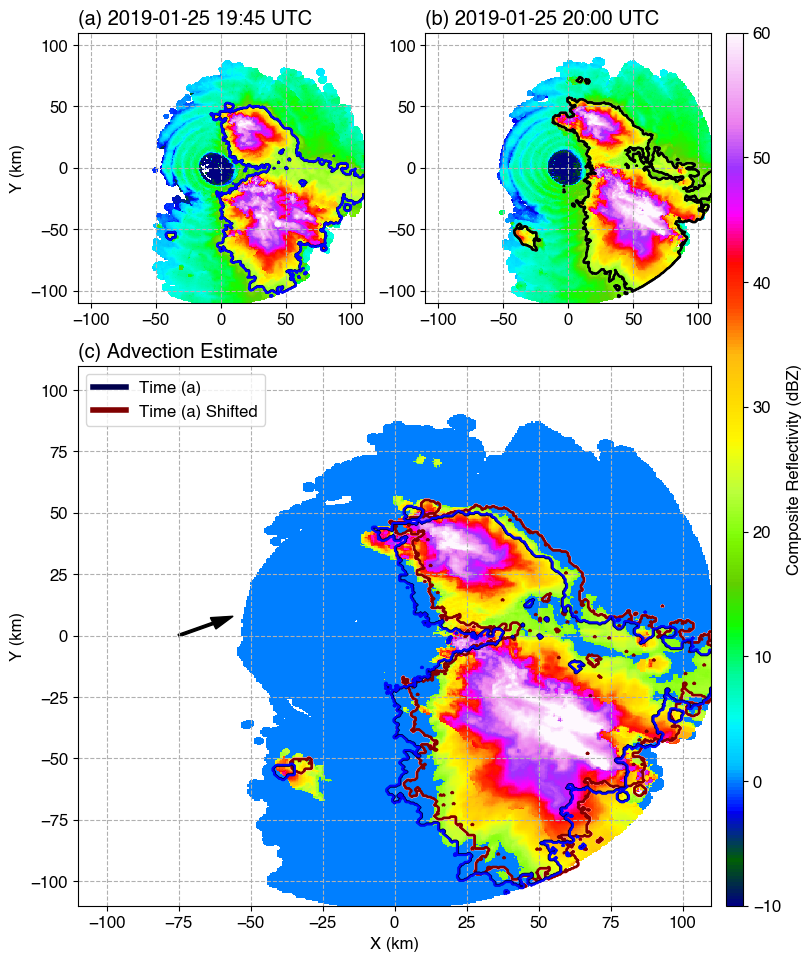

In [154]:
y_lag, x_lag = movement_of_storm_fft(dset_1, dset_2, figname=figname, plot_subplots=True, threshold=20)
mag_movement, mag_dir, mag_movement_mps = offset_to_speed(x_lag, y_lag, 15 * 60)
print(x_lag)
print(y_lag)
print(mag_movement)
print(mag_dir)
print(mag_movement_mps)

In [66]:
# field_1 = np.squeeze(dset_1['dbz_comp'].values)
# field_2 = np.squeeze(dset_2['dbz_comp'].values)
# xx = dset_1.x.values / 1000.
# yy = dset_1.y.values / 1000.

# timestr1 = dset_1.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
# timestr2 = dset_2.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
# fignametimestr = dset_1.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
# timestr1, timestr2, fignametimestr

In [112]:
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'Helvetica'

# fig = plt.figure(constrained_layout=True, figsize=[8,10], dpi=100)
# gs = fig.add_gridspec(3, 3, height_ratios=[1,1,1], width_ratios=[1,1,0.06])
# gs.update(right=0.8, wspace=0.06, hspace=0.05)

# ax1 = fig.add_subplot(gs[0, 0])
# pcm1 = ax1.pcolormesh(xx,yy, field_1, vmin=-10, vmax=60, cmap='gist_ncar')
# ax1.set_title('Time1', loc='left')
# ax1.set_ylabel('Y (km)')
# ax2 = fig.add_subplot(gs[0, 1])
# pcm2 = ax2.pcolormesh(xx,yy, field_2, vmin=-10, vmax=60, cmap='gist_ncar')
# ax2.set_title('Time2', loc='left')
# ax3 = fig.add_subplot(gs[1:, 0:2])
# pcm3 = ax3.pcolormesh(xx,yy, field_2, vmin=-10, vmax=60, cmap='gist_ncar')
# ax3.set_title('Time1,2', loc='left')
# ax3.set_xlabel('X (km)')
# ax3.set_ylabel('Y (km)')
# # Colorbar
# cb_ax = fig.add_subplot(gs[:,2])
# cbar = fig.colorbar(pcm1, cax=cb_ax, label='Reflectivity (dBZ)')